In [1]:
from rfe import df_selected,symbol
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

         Low   Close       date
677   252.00  260.98 2016-07-17
678   265.93  278.32 2016-07-18
679   273.05  283.89 2016-07-19
680   277.70  285.75 2016-07-20
681   278.32  281.41 2016-07-21
...      ...     ...        ...
2431  422.00  433.50 2024-03-12
2432  428.00  432.00 2024-03-13
2433  425.10  425.10 2024-03-14
2434  417.00  418.00 2024-03-17
2435  416.00  418.20 2024-03-18

[1759 rows x 3 columns]


2024-03-25 11:12:56.968314: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 11:12:57.220523: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 11:12:57.222309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 11:12:58.447075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
df_selected = df_selected.sort_values(by='date',ascending=False)

In [5]:
df = df_selected
df['Date'] = pd.to_datetime(df['date'])
df = df.set_index('Date')

In [6]:
df 

,Low,Close,date
Date,,,
2024-03-18,416.00,418.20,2024-03-18
2024-03-17,417.00,418.00,2024-03-17
2024-03-14,425.10,425.10,2024-03-14
2024-03-13,428.00,432.00,2024-03-13
2024-03-12,422.00,433.50,2024-03-12
...,...,...,...
2016-07-21,278.32,281.41,2016-07-21
2016-07-20,277.70,285.75,2016-07-20
2016-07-19,273.05,283.89,2016-07-19


In [26]:
df.tail()

,Low,Close,date,col
Date,,,,
2016-07-21,278.32,281.41,2016-07-21,278.32
2016-07-20,277.70,285.75,2016-07-20,277.70
2016-07-19,273.05,283.89,2016-07-19,273.05
2016-07-18,265.93,278.32,2016-07-18,265.93
2016-07-17,252.00,260.98,2016-07-17,252.00


In [29]:
scaler = MinMaxScaler()
df['Close'] = df['Close'].astype(float)
df_scaled = scaler.fit_transform(df[['Close']])
df_scaled

array([[0.3839577 ],
       [0.38365979],
       [0.3942355 ],
       ...,
       [0.18389812],
       [0.1756014 ],
       [0.14977285]])

In [27]:
def create_dataset(df_scaled, look_back=50):
  x_train = []
  y_train = []
  for i in range(len(df_scaled) - look_back):
    x_train.append(df_scaled[i:i + look_back])
    y_train.append(df_scaled[i + look_back])
  return x_train, y_train

In [9]:


sequence_length = 10
X, y = create_dataset(df_scaled, sequence_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [11]:
model = Sequential()
model.add(LSTM(50, activation='sigmoid', return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, activation='tanh'))

model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

2024-03-25 11:19:21.164530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 11:19:21.165370: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
# Convert lists to arrays and reshape for LSTM input
X_train = np.array(X_train).reshape((len(X_train), sequence_length, 1))
X_test = np.array(X_test).reshape((len(X_test), sequence_length, 1))

In [13]:
y_train = np.array(y_train).reshape((len(y_train), 1))
y_test = np.array(y_test).reshape((len(y_test), 1))
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=2)

     

Epoch 1/150
44/44 - 3s - loss: 0.2128 - val_loss: 0.1231 - 3s/epoch - 66ms/step
Epoch 2/150
44/44 - 0s - loss: 0.0769 - val_loss: 0.1560 - 363ms/epoch - 8ms/step
Epoch 3/150
44/44 - 0s - loss: 0.0693 - val_loss: 0.1169 - 346ms/epoch - 8ms/step
Epoch 4/150
44/44 - 0s - loss: 0.0137 - val_loss: 0.0021 - 354ms/epoch - 8ms/step
Epoch 5/150
44/44 - 0s - loss: 0.0014 - val_loss: 5.2095e-04 - 329ms/epoch - 7ms/step
Epoch 6/150
44/44 - 0s - loss: 9.6774e-04 - val_loss: 4.3125e-04 - 328ms/epoch - 7ms/step
Epoch 7/150
44/44 - 0s - loss: 7.0908e-04 - val_loss: 3.2148e-04 - 383ms/epoch - 9ms/step
Epoch 8/150
44/44 - 0s - loss: 6.2414e-04 - val_loss: 1.7197e-04 - 329ms/epoch - 7ms/step
Epoch 9/150
44/44 - 0s - loss: 5.6815e-04 - val_loss: 1.8511e-04 - 331ms/epoch - 8ms/step
Epoch 10/150
44/44 - 0s - loss: 5.5553e-04 - val_loss: 1.5151e-04 - 344ms/epoch - 8ms/step
Epoch 11/150
44/44 - 0s - loss: 5.4381e-04 - val_loss: 2.0099e-04 - 323ms/epoch - 7ms/step
Epoch 12/150
44/44 - 0s - loss: 6.2760e-04 - v

In [14]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

11/11 [==============================] - 0s 3ms/step


In [15]:
train_predictions = scaler.inverse_transform(train_predictions)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predictions = scaler.inverse_transform(test_predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

In [16]:
y_train_original

array([[406.  ],
       [408.  ],
       [413.  ],
       ...,
       [186.81],
       [183.58],
       [183.58]])

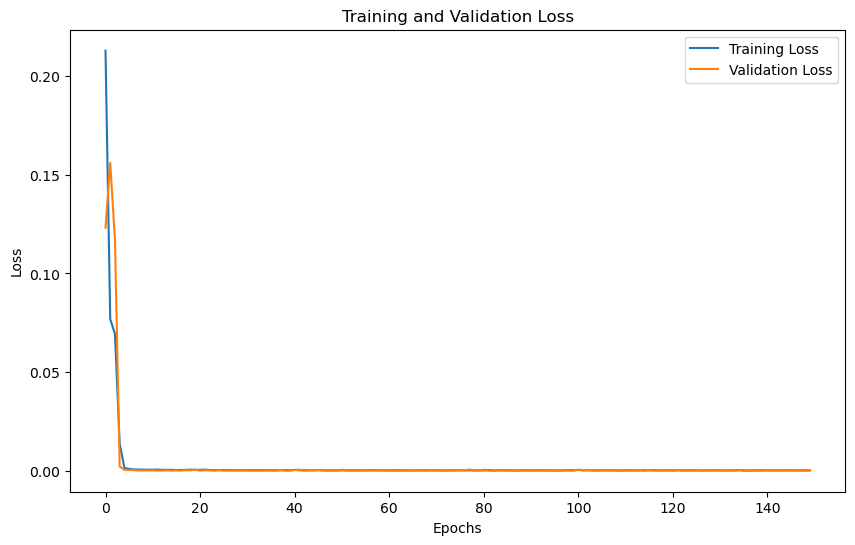

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

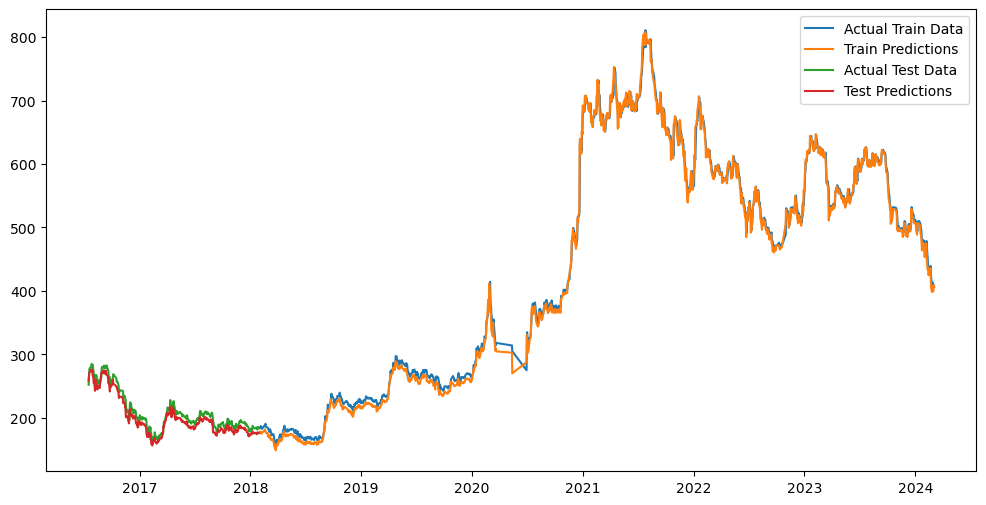

In [18]:
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(df.index[sequence_length:sequence_length+train_size], y_train_original, label='Actual Train Data')
plt.plot(df.index[sequence_length:sequence_length+train_size], train_predictions, label='Train Predictions')
# Plot testing data
test_index = df.index[sequence_length + train_size:sequence_length + train_size + len(test_predictions)]
plt.plot(test_index, y_test_original, label='Actual Test Data')
plt.plot(test_index, test_predictions, label='Test Predictions')

plt.legend()
plt.show()

In [20]:
df = df.sort_index(ascending=False)

# Scale the most recent data
latest_data = df.head(sequence_length)
latest_scaled = scaler.transform(latest_data[['col']])
print(df['date'])

# Reshape the scaled data
latest_scaled = np.array(latest_scaled).reshape((1, sequence_length, 1))

# Predict tomorrow's price
tomorrow_prediction = model.predict(latest_scaled)
tomorrow_prediction = scaler.inverse_transform(tomorrow_prediction)

print("Tomorrow's predicted price:", tomorrow_prediction[0])

Date
2024-03-18   2024-03-18
2024-03-17   2024-03-17
2024-03-14   2024-03-14
2024-03-13   2024-03-13
2024-03-12   2024-03-12
                ...    
2016-07-21   2016-07-21
2016-07-20   2016-07-20
2016-07-19   2016-07-19
2016-07-18   2016-07-18
2016-07-17   2016-07-17
Name: date, Length: 1759, dtype: datetime64[ns]
1/1 [==============================] - 0s 24ms/step
Tomorrow's predicted price: [409.44876]


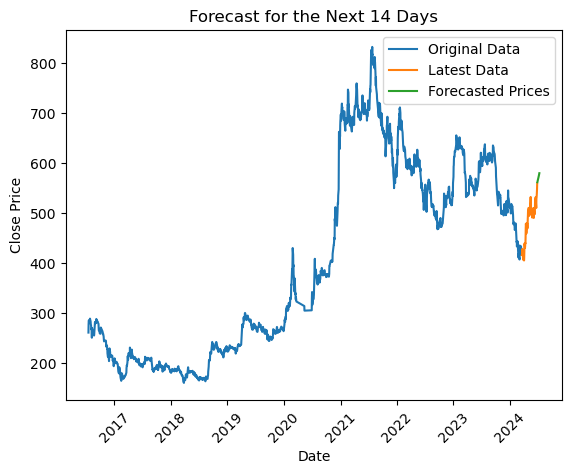

array([[561.47911384],
       [562.64091837],
       [564.08042902],
       [565.45657707],
       [566.7621916 ],
       [568.07387985],
       [569.38936907],
       [570.73115162],
       [572.10016794],
       [573.50335383],
       [574.94196322],
       [576.41862152],
       [577.93434755],
       [579.49106139]])

In [24]:
# Define the number of days to consider for forecasting
n_days_to_consider = 100

# Use the first 100 days of data for forecasting
latest_data = df_scaled[:n_days_to_consider]

# Initialize temp_input with the latest data
temp_input = list(latest_data.reshape(-1))

lst_output = []

# Generating the forecast for the next 10 days
for i in range(14):
    if len(temp_input) > n_days_to_consider:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, n_days_to_consider, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())

# Inverse transform the forecasted values
forecast_inv = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Generate arrays for plotting
latest_dates = pd.date_range(start=df.index[0], periods=n_days_to_consider)  # Dates for the latest data
forecast_dates = pd.date_range(start=latest_dates[-1] + pd.Timedelta(days=1), periods=14)  # Dates for the forecast

# Plotting
plt.plot(df.index, df['Close'], label='Original Data')
plt.plot(latest_dates, scaler.inverse_transform(latest_data), label='Latest Data')
plt.plot(forecast_dates, forecast_inv, label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Forecast for the Next 14 Days')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

forecast_inv

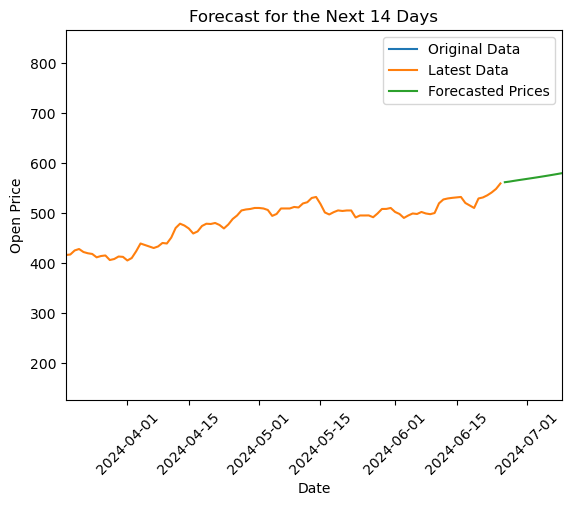

In [25]:
plt.plot(df.index, df['Close'], label='Original Data')
plt.plot(latest_dates, scaler.inverse_transform(latest_data), label='Latest Data')
plt.plot(forecast_dates, forecast_inv, label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Forecast for the Next 14 Days')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Expand the x-axis limits
plt.xlim(df.index[0], forecast_dates[-1])

plt.show()